# Ratio Simulations

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import skimage.segmentation
import skimage.transform
from skimage import io
import tifffile

from nima import nima

SHAPE = (1038, 1388)
cm = plt.cm.inferno_r

## Simulate Poisson Distribution for 3 Signals (and Backgrounds)

(array([   44.,   696.,  5426., 19021., 31875., 27356., 12186.,  2921.,
          433.,    42.]),
 array([16.78033413, 19.46717253, 22.15401092, 24.84084932, 27.52768772,
        30.21452611, 32.90136451, 35.5882029 , 38.2750413 , 40.9618797 ,
        43.64871809]),
 [<matplotlib.patches.Polygon at 0x744e88120710>])

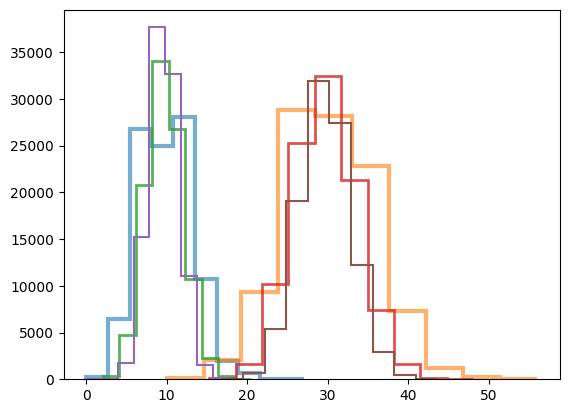

In [2]:
N = 100000

bg1 = np.random.poisson(10, N)
bg2 = np.random.poisson(10, N)
bg3 = np.random.poisson(10, N)
s1 = np.random.poisson(30, N)
s2 = np.random.poisson(30, N)
s3 = np.random.poisson(30, N)

plt.hist(bg1, histtype="step", lw=3, alpha=0.6)
plt.hist(s1, histtype="step", lw=3, alpha=0.6)

plt.hist(np.sqrt(bg1 * bg2), histtype="step", lw=2, alpha=0.8)
plt.hist(np.sqrt(s1 * s2), histtype="step", lw=2, alpha=0.8)

plt.hist(np.power(bg1 * bg2 * bg3, 1 / 3), histtype="step", lw=1.5, alpha=1)
plt.hist(np.power(s1 * s2 * s3, 1 / 3), histtype="step", lw=1.5, alpha=1)

### power vs. average for 3 channels

In [ ]:
plt.hist(np.average([bg1, bg2, bg3], axis=0), histtype="step", lw=1.5, alpha=1)
plt.hist(np.average([s1, s2, s3], axis=0), histtype="step", lw=1.5, alpha=1)

plt.hist(np.power(bg1 * bg2 * bg3, 1 / 3), histtype="step", lw=3, alpha=1)
plt.hist(np.power(s1 * s2 * s3, 1 / 3), histtype="step", lw=3, alpha=1)

In [ ]:
def hp(bg1, bg2, s1, s2, N=1000):
    bgv1 = np.random.poisson(bg1, N)
    bgv2 = np.random.poisson(bg2, N)
    sv1 = np.random.poisson(s1, N)
    sv2 = np.random.poisson(s2, N)
    plt.figure()
    plt.hist(np.sqrt(bgv1 * bgv2), histtype="step", lw=3, alpha=0.6)
    plt.hist(np.sqrt(sv1 * sv2), histtype="step", lw=3, alpha=0.6)
    plt.hist(np.sqrt(sv1 * bgv1), histtype="step", lw=3, alpha=0.6)


hp(10, 10, 30, 30)

hp(100, 100, 300, 300)

In [ ]:
hp(100, 100, 150, 150)

In [ ]:
hp(10, 11, 23, 22, N=10000)

## Simulate image objects with variable intensity

The idea is to simulate signal intensity variation with a parabola.

Model is: offset + dark_current + bg + target

We set offset to zero, then we have 3 poisson noises from dark_current, bg and target. But we simulate only bg and target to simplify our simulation.

In [ ]:
import seaborn as sb

a = np.random.poisson(3, size=90000)
b = np.random.poisson(7, size=90000)
c = a + b
d = np.random.poisson(10, size=90000)

ax = sb.histplot(c, color="blue", label="c")
ax = sb.histplot(d, color="orange", label="d")
ax.legend()
print("c", scipy.stats.normaltest(c))
print("d", scipy.stats.normaltest(d))

# Fit a normal distribution to the data
mu, std = scipy.stats.norm.fit(c)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std) * sum(d) / mu
# Plot the fitted distribution curve on top of the histogram
ax.plot(x, p, "blue", linewidth=1)
ax.set_title(f"Histogram with Fitted Normal Distribution (mu={mu:.2f}, std={std:.2f})")

# Fit a normal distribution to the data
mu, std = scipy.stats.norm.fit(c)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std) * sum(c) / mu
# Plot the fitted distribution curve on top of the histogram
ax.plot(x, p, "orange", linewidth=1)
ax.set_title(f"Histogram with Fitted Normal Distribution (mu={mu:.2f}, std={std:.2f})")

In [ ]:
g = scipy.stats.probplot(d, plot=plt, dist="poisson", sparams=(10))

### with N >= 10000 Poissonian == Gaussian for 90000 values (pixels)

In [ ]:
a = (
    skimage.util.random_noise(
        1000 * np.ones((300, 300)).astype(float), mode="poisson", clip=False
    )
    / 1000
)
print("N =  1000", scipy.stats.normaltest(a.ravel()))
a = (
    skimage.util.random_noise(
        5000 * np.ones((300, 300)).astype(float), mode="poisson", clip=False
    )
    / 1000
)
print("N =  5000", scipy.stats.normaltest(a.ravel()))
a = (
    skimage.util.random_noise(
        10000 * np.ones((300, 300)).astype(float), mode="poisson", clip=False
    )
    / 1000
)
print("N = 10000", scipy.stats.normaltest(a.ravel()))

In [ ]:
def parabola(x, bl, s, f=1):
    D = f * s + bl + s
    x_i = x[0]
    x_m = np.median(x)
    a = -f * s / (x_i - x_m) ** 2
    b = -2 * a * x_m
    c = D + a * x_m**2
    y = a * x**2 + b * x + c
    return y


x = np.arange(-6, 16)
plt.plot(x[3:-3], parabola(x[3:-3], 1, 10, f=0.1), "-v")
plt.grid()

In [ ]:
def parabola_2d(im, bl, s, f=1):
    x, y = np.indices(im.shape)
    D = f * s + bl + s
    x_i = x[0, 0]
    y_i = y[0, 0]
    x_m = np.median(x[:, 0])
    y_m = np.median(y[0, :])
    ax = -f * s / (x_i - x_m) ** 2
    ay = -f * s / (y_i - y_m) ** 2
    bx = -2 * ax * x_m
    by = -2 * ay * y_m
    cx = D + ax * x_m**2
    cy = D + ay * y_m**2
    z = ax * x**2 + ay * y**2 + bx * x + by * y + cx / 2 + cy / 2
    return z


im = np.ones((11, 11))
bg = 2
z1 = parabola_2d(im[3:-3, 2:-2], bg, 1, f=0.2)
skimage.io.imshow(z1)
z1.shape
plt.figure()
plt.plot(z1[int(z1.shape[0] / 2), :])
plt.plot(z1[0, :], "--")
plt.plot(z1[:, int(z1.shape[1] / 2)])
# plt.figure()
# mask = z>11.3
# skimage.io.imshow(mask)

z2 = parabola_2d(im[3:-3, 2:-2], bg, 2, f=0.2)
(z2 - bg) / (z1 - bg)

In [ ]:
# new simulator 1D
def sim1d(bl=1, s=1, s_var=1, f=10, gain=10, shape=50, idx_mask=[6, -6]):
    x = np.arange(shape)
    y = np.ones_like(x).astype(float)
    m = np.zeros_like(x).astype(bool)
    m[idx_mask[0] : idx_mask[1]] = True
    # first bg (skyglow) noise in all the image vs. ##y[~m] = bl
    y = (
        skimage.util.random_noise(
            bl * gain * np.ones_like(x).astype(float), mode="poisson", clip=False
        ).clip(0)
        / gain
    )
    y[m] += parabola(x[m], bl=0, s=s, f=f)
    # plus other noise drom the target
    y[m] = (
        skimage.util.random_noise(gain * y.astype(float), mode="poisson", clip=False)[
            m
        ].clip(0)
        / gain
    )
    return x, y, m


plt.figure(figsize=(12, 4))
plt.subplot(121)
x, y, m = sim1d(gain=1, s=22, f=0.5)
plt.plot(x, y, "ok")
x2, y2, m2 = sim1d(gain=1, s=44, f=0.5)
plt.plot(x2, y2, "ob")
plt.subplot(122)
bl = 1
ratio = (y2[m] - bl) / (y[m] - bl)
plt.plot(x[m], ratio)

plt.plot(x[m], pd.DataFrame(ratio).rolling(window=15, center=True).median(), lw=2)
plt.plot(x[m], pd.DataFrame(ratio).rolling(window=15, center=True).mean(), lw=2)

scipy.stats.normaltest(ratio)

In [ ]:
# new simulator 2D
def sim_2d(bl=1, s=1, s_var=1, f=1, gain=10, shape=(7, 7), idx_mask=[1, -1, 1, -1]):
    im = np.ones(shape).astype(float)
    ###y = np.ones_like(x).astype(float)
    m = np.zeros_like(im).astype(bool)
    m[idx_mask[0] : idx_mask[1], idx_mask[2] : idx_mask[3]] = True
    # first bg (skyglow) noise in all the image vs. ##y[~m] = bl
    im = (
        skimage.util.random_noise(
            bl * gain * np.ones_like(im).astype(float), mode="poisson", clip=False
        ).clip(0)
        / gain
    )
    # TODO: usare una maschera arbitraria senza conversion 2d -> 1d
    im[idx_mask[0] : idx_mask[1], idx_mask[2] : idx_mask[3]] += parabola_2d(
        im[idx_mask[0] : idx_mask[1], idx_mask[2] : idx_mask[3]], bl=0, s=s, f=f
    )
    # plus other noise drom the target
    im[idx_mask[0] : idx_mask[1], idx_mask[2] : idx_mask[3]] = (
        skimage.util.random_noise(
            gain
            * im[idx_mask[0] : idx_mask[1], idx_mask[2] : idx_mask[3]].astype(float),
            mode="poisson",
            clip=False,
        ).clip(0)
        / gain
    )
    return im, m


bg = 5
im1, m1 = sim_2d(
    shape=(1000, 2000), idx_mask=[200, -600, 500, -300], s=4, gain=1, f=5, bl=bg
)
im2, m2 = sim_2d(
    shape=(1000, 2000), idx_mask=[200, -600, 500, -300], s=8, gain=1, f=5, bl=bg
)

ratio = (im2 * m2 - bg) / (im1 * m1 - bg)
plt.figure(figsize=(14, 6))
plt.subplot(131)
io.imshow(ratio)
plt.subplot(132)
ratio_median = scipy.ndimage.filters.median_filter(ratio, 5)
io.imshow(ratio_median)

plt.subplot(133)
nima.myhist(ratio[m1], log=1)
nima.myhist(ratio_median[m1], log=1)

axins = plt.axes([0.14, 0.11, 0.28, 0.3])
plt.plot(ratio[300, 500:-300], lw=0.2)
plt.plot(ratio_median[300, 500:-300])
axins2 = plt.axes([0.42, 0.11, 0.08, 0.3])
plt.hist(ratio[300, 500:-300], alpha=0.6, orientation="horizontal", bins=50)
axins2.set_ylim(axins.get_ylim())
axins2.set_yticks([])
axins3 = plt.axes([0.50, 0.11, 0.08, 0.3])
plt.hist(ratio_median[300, 500:-300], alpha=0.6, orientation="horizontal", bins=50)
axins3.set_ylim(axins.get_ylim())
axins3.set_yticks([])

print(scipy.stats.normaltest(ratio[m1]))
print(scipy.stats.normaltest(ratio_median[m1]))
print(scipy.stats.normaltest(ratio_median[300, 500:-300]))
axins4 = plt.axes([0.4, 0.66, 0.08, 0.22])
scipy.stats.probplot(ratio[m1], plot=axins4)
axins5 = plt.axes([0.5, 0.66, 0.08, 0.22])
scipy.stats.probplot(ratio_median[m1], plot=axins5)


im1 = (im1 - bg).clip(0)
im2 = (im2 - bg).clip(0)

qui voglio simulare fret e bt:
$$
    S^{561} = R \\
    S^{488} = G (1 - E) + R (\alpha + E) \\
    S^{458} = C (1 - E) + R (\beta + E)
$$

In [ ]:
im1, m1 = sim_2d(shape=(100, 200), idx_mask=[20, -20, 30, -30], s=2, gain=1, f=5, bl=bg)
im2, m2 = sim_2d(shape=(100, 200), idx_mask=[20, -20, 30, -30], s=4, gain=1, f=5, bl=bg)
N = im1[20:-20, 30:-30] - 5
D = im2[20:-20, 30:-30] - 5
tifffile.imshow(N / D)
fm = skimage.filters.median(N / D, footprint=skimage.morphology.disk(5))
tifffile.imshow(fm)
nima.myhist(fm, nf=1, log=1)

Note that the ratio (either filtered or not filtered) is not distributed according to a gaussian; there are remarkable differences on the tails as can be easily noted in the q-q plot.

### Testing segmentation pipeline

In [ ]:
nima.myhist(im1)
nima.myhist(im2)
ga = np.sqrt(im1 * im2)  # can be negative
aa = (im1 + im2) / 2
nima.myhist(ga)
nima.myhist(aa, log=True)
plt.legend(["1", "2", "g.a.", "a.a."])


plt.figure(figsize=(16, 8))
plt.subplot(151)
thr = skimage.filters.threshold_li(im1.copy())
mm = im1 > thr
mm1 = mm
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("im: " + str((m1 - mm).sum()))

plt.subplot(152)
thr = skimage.filters.threshold_li(im2.copy())
mm = im2 > thr
mm2 = mm
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("im2: " + str((m1 - mm).sum()))

plt.subplot(153)
thr = skimage.filters.threshold_li(ga.copy())
mm = ga > thr
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
m3 = mm
plt.imshow(mm)
plt.contour(m1)
plt.title("ga: " + str((m1 - mm).sum()))

plt.subplot(154)
thr = skimage.filters.threshold_li(aa.copy())
mm = aa > thr
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("aa: " + str((m1 - mm).sum()))

plt.subplot(155)
mm = mm1 & mm2
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("1U2: " + str((m1 - mm).sum()))

plt.figure()
plt.imshow(m3)

Before moving to the 3-channel simulation. No doubt, the first opening (or erosion-propagation) is really necessary to remove false positive pixels in the bg. Then the results strongly depends on the bl value, the signal value, the gain, (maybe less on the *f*). It happened that the single image with the best s/n ratio was the best predictor.

With the final binary closing, however, the geometric average seems the best way to perform segmentation.

I will probably test with few other ideas like CC.

Note: remove small objects seems equivalent to erosion-propagation and better then just opening.


### with 3 channels

In [ ]:
bg = 5
im1, m1 = sim_2d(
    shape=(1000, 2000), idx_mask=[200, -600, 500, -300], s=4, gain=1, f=5, bl=bg
)
im2, m2 = sim_2d(
    shape=(1000, 2000), idx_mask=[200, -600, 500, -300], s=8, gain=1, f=5, bl=bg
)
im3, m3 = sim_2d(
    shape=(1000, 2000), idx_mask=[200, -600, 500, -300], s=6, gain=1, f=5, bl=bg
)
im1 = (im1 - bg).clip(0)
im2 = (im2 - bg).clip(0)
im3 = (im3 - bg).clip(0)

In [ ]:
nima.myhist(im1)
nima.myhist(im2)
nima.myhist(im3)
ga = np.power(im1 * im2 * im3, 1 / 3)  # can be negative
aa = (im1 + im2 + im3) / 3
nima.myhist(ga)
nima.myhist(aa, log=True)
plt.legend(["1", "2", "3", "g.a.", "a.a."])
thr = skimage.filters.threshold_li(im3.copy())
mm = im3 > thr
mm3 = mm

plt.figure(figsize=(16, 8))
plt.subplot(151)
thr = skimage.filters.threshold_li(im1.copy())
mm = im1 > thr
mm1 = mm
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("im: " + str((m1 - mm).sum()))

plt.subplot(152)
thr = skimage.filters.threshold_li(im2.copy())
mm = im2 > thr
mm2 = mm
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("im2: " + str((m1 - mm).sum()))

plt.subplot(153)
thr = skimage.filters.threshold_li(ga.copy())
mm = ga > thr
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
##mm = skimage.morphology.remove_small_objects(mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
m3 = mm
plt.imshow(mm)
plt.contour(m1)
plt.title("ga: " + str((m1 - mm).sum()))

plt.subplot(154)
thr = skimage.filters.threshold_li(aa.copy())
mm = aa > thr
mmtmp = scipy.ndimage.binary_erosion(mm)
mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("aa: " + str((m1 - mm).sum()))

plt.subplot(155)
mm = mm1 | mm2 | mm3
mm = skimage.morphology.remove_small_objects(mm)
##mmtmp = scipy.ndimage.binary_erosion(mm)
##mm = scipy.ndimage.binary_propagation(mmtmp, mask=mm)
# mm = skimage.morphology.opening(mm)  # opening
mm = skimage.morphology.closing(mm)
plt.imshow(mm)
plt.contour(m1)
plt.title("1U2: " + str((m1 - mm).sum()))

plt.figure()
plt.imshow(m3)

### target segmentation pipeline

* geometric average of ch1, ch2, ch3, ... (after bg subtraction)
* binary erosion-propagation (or remove_small_object)
* binary closing (remove small_holes is not present in this moment)


construction of synthetic data:

it is 3D object, intensity level in each voxel, convolution with microscope PSF, then add error.

But so shot noise from one plane only will be added rather than shot noise from the planes above and below. Maybe the use of higher noise for a given plane is equivalent to the sum of noises coming from each individual plane?

In [ ]:
offset = 50
bg = 10

x, y = np.indices((50, 50))
m = (x - 25) ** 2 + (y - 25) ** 2

# mask
im = -m
m = m <= 400
plt.figure(figsize=(12, 5))
plt.subplot(151)
skimage.io.imshow(m, cmap=plt.cm.inferno_r)
# bg poisson error
im = im.astype(float)
im += np.abs(im[m].min()) + offset
im[~m] = skimage.util.random_noise(
    10 * np.ones_like(im).astype(float), mode="poisson", clip=False
)[~m]
im2 = im * 2
plt.subplot(152)
skimage.io.imshow(im2, cmap=plt.cm.inferno_r)
# fg gauss error
im2[m] += skimage.util.random_noise(
    np.zeros_like(im2).astype("float64"), mode="gaussian", var=200, clip=False
)[m]
im[m] += skimage.util.random_noise(
    np.zeros_like(im2).astype("float64"), mode="gaussian", var=100, clip=False
)[m]
plt.subplot(153)
skimage.io.imshow(im2, cmap=plt.cm.inferno_r)
plt.subplot(154)
plt.plot(im[25, :], "o")
plt.plot(im2[25, :])
plt.yscale("log")

plt.subplot(155)
r = im2 / im
plt.plot(r[25, :])

In [ ]:
plt.imshow(m - mm)
m.sum() - mm.sum(),

In [ ]:
from scipy.ndimage.filters import correlate as ic

x = numpy.array(N)
hist(ic(s1, b3)), hist(ic(s1, s3)), hist(ic(b1, b3)),